# Chapter 3, demos 1-4

Bayesian Data Analysis, 3rd ed

Examples and illustrations for a normal model with unknown mean and variance (BDA3 section 3.2 on p. 64).

In [1]:
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import preliz as pz
pz.style.use('preliz-doc')

In [2]:
# data
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])
# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # here ddof=1 is used to get the sample estimate
my = np.mean(y)

In [3]:
# set random number generator with seed
rng = np.random.default_rng(0)

In [4]:
# factorize the joint posterior p(mu,sigma2|y) to p(sigma2|y)p(mu|sigma2,y)
# sample from the joint posterior using this factorization

# sample from p(sigma2|y)
sigma2 = pz.ScaledInverseChiSquared(n-1, s2).rvs(size=1000, random_state=rng)
# sample from p(mu|sigma2,y) 
mu = my + np.sqrt(sigma2/n)* pz.Normal(0, 1).rvs(sigma2.shape)
# display sigma instead of sigma2
sigma = np.sqrt(sigma2)
# sample from the predictive distribution p(ynew|y)
# for each sample of (mu, sigma)
ynew = pz.Normal(mu, sigma).rvs(*mu.shape)

In [5]:
# for mu compute the density in these points
tl1 = [90, 150]
t1 = np.linspace(tl1[0], tl1[1], 1000)
# for sigma compute the density in these points
tl2 = [10, 60]
t2 = np.linspace(tl2[0], tl2[1], 1000)
# for ynew compute the density in these points
tlynew = [50, 185]
xynew = np.linspace(tlynew[0], tlynew[1], 1000)

# evaluate the joint density in a grid
# note that the following is not normalized, but for plotting
# contours it does not matter
Z = pz.Normal(my, t2[:,np.newaxis]/np.sqrt(n)).pdf(t1)
Z *= (pz.ScaledInverseChiSquared(n-1, s2).pdf(t2**2)*2*t2)[:,np.newaxis]

# compute the exact marginal density for mu
pm_mu = pz.StudentT(n-1, my, np.sqrt(s2/n)).pdf(t1)

# estimate the marginal density for mu using samples and an ad hoc Gaussian
# kernel approximation
pk_mu = gaussian_kde(mu).evaluate(t1)

# compute the exact marginal density for sigma
# multiplication by 2*t2 is due to the transformation of variable
# z=t2^2, see BDA3 p. 21
pm_sigma = pz.ScaledInverseChiSquared(n-1, s2).pdf(t2**2)*2*t2
# N.B. this was already calculated in the joint distribution case

# estimate the marginal density for sigma using samples and an ad hoc Gaussian
# kernel approximation
pk_sigma = gaussian_kde(sigma).evaluate(t2)

# compute the exact predictive density
p_new = pz.StudentT(n-1, my, np.sqrt(s2*(1+1/n))).pdf(xynew)

Visualise the joint density and marginal densities of the posterior of normal 
distribution with unknown mean and variance.

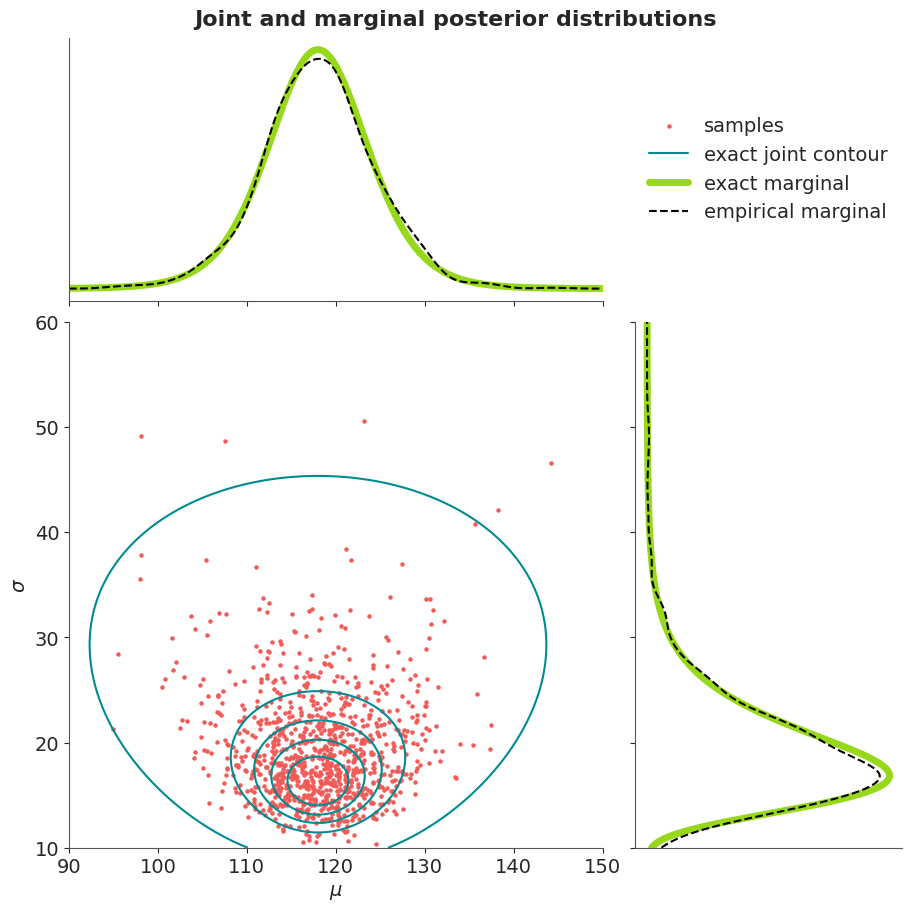

In [6]:
# Create figure
fig, ((ax_mu, ax_legend), (ax_joint, ax_sigma)) = plt.subplots(
    2, 2, figsize=(9, 9),
    gridspec_kw=dict(width_ratios=[2, 1], height_ratios=[1, 2])
)
fig.suptitle("Joint and marginal posterior distributions", fontsize=16)

# Joint posterior
samps = ax_joint.scatter(mu, sigma, s=5, color="C2")
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax_joint.contour(t1, t2, Z, c_levels, colors="C0")
ax_joint.set(xlim=tl1, ylim=tl2, xlabel=r"$\mu$", ylabel=r"$\sigma$")

# Marginal of μ
ax_mu.plot(t1, pm_mu, color="C1", lw=5, label="exact marginal")
ax_mu.plot(t1, pk_mu, "k--", lw=1.5, label="empirical marginal")
ax_mu.set(xlim=tl1, yticks=[], xticklabels=[])

# Marginal of σ
exact_line, = ax_sigma.plot(pm_sigma, t2, color="C1", lw=5)
empirical_line, = ax_sigma.plot(pk_sigma, t2, "k--", lw=1.5)
ax_sigma.set(ylim=tl2, xticks=[], yticklabels=[])

# Legend 
ax_legend.axis("off")
ax_legend.legend(
    [samps, plt.Line2D([], [], color="C0"), exact_line, empirical_line],
    ["samples", "exact joint contour", "exact marginal", "empirical marginal"],
    loc="center"
);

Visualise factored sampling and the corresponding marginal and conditional densities.

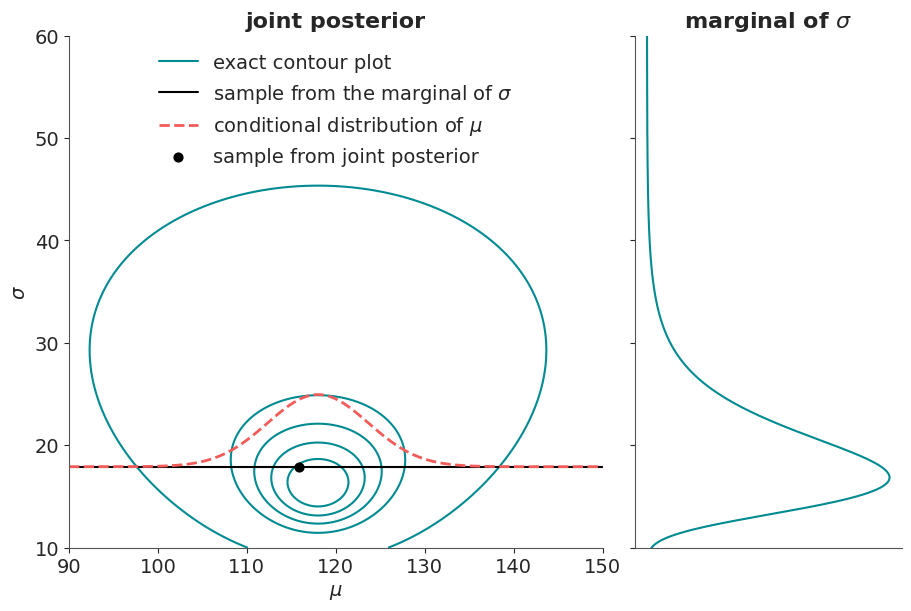

In [7]:
# Create figure
fig, (ax_joint, ax_sigma) = plt.subplots(
    1, 2, figsize=(9, 6),
    gridspec_kw=dict(width_ratios=[2, 1])
)

# Joint posterior
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
contour = ax_joint.contour(t1, t2, Z, c_levels, colors="C0")

line1 = ax_joint.axhline(sigma[0], color="k")
line2, = ax_joint.plot(
    t1,
    sigma[0] + pz.Normal(my, np.sqrt(sigma2[0] / n)).pdf(t1) * 100,
    "C2--", lw=2
)
scat = ax_joint.scatter(mu[0], sigma[0], s=40, color="k", zorder=3)

ax_joint.set(
    xlim=tl1, ylim=tl2,
    xlabel=r"$\mu$", ylabel=r"$\sigma$",
    title="joint posterior"
)
ax_joint.legend(
    [plt.Line2D([], [], color="C0"), line1, line2, scat],
    [
        "exact contour plot",
        r"sample from the marginal of $\sigma$",
        r"conditional distribution of $\mu$",
        r"sample from joint posterior",
    ],
    loc="upper center"
)

# Marginal of σ
ax_sigma.plot(pm_sigma, t2)
ax_sigma.set(ylim=tl2, title=r"marginal of $\sigma$", xticks=[], yticklabels=[]);

Visualise the marginal distribution of mu as a mixture of normals.

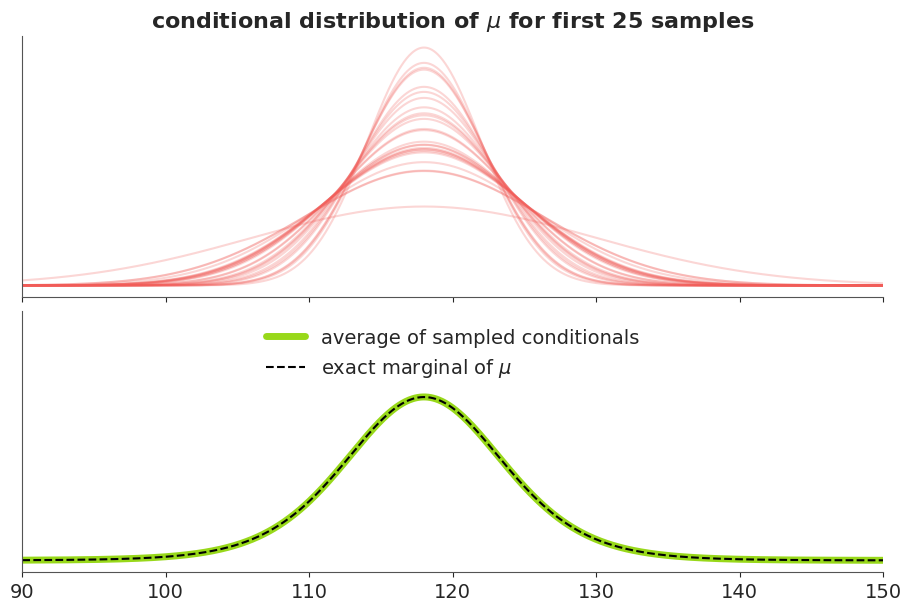

In [8]:
# Compute conditional PDFs
condpdfs = pz.Normal(my, np.sqrt(sigma2 / n)[:, None]).pdf(t1)

fig, (ax_cond, ax_mean) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

# First 25 conditional distributions
ax_cond.plot(t1, condpdfs[:25].T, "C2", alpha=0.25)
ax_cond.set(
    xlim=tl1,
    title=r"conditional distribution of $\mu$ for first 25 samples",
    yticks=[]
)
ylims = ax_cond.get_ylim()

# average of conditionals vs exact marginal
ax_mean.plot(t1, condpdfs.mean(axis=0), "C1", lw=5, label="average of sampled conditionals")
ax_mean.plot(t1, pm_mu, "k--", lw=1.5, label=r"exact marginal of $\mu$")
ax_mean.set(xlim=tl1, ylim=ylims, yticks=[])
ax_mean.legend(loc="upper center");


Visualise sampling from the posterior predictive distribution.

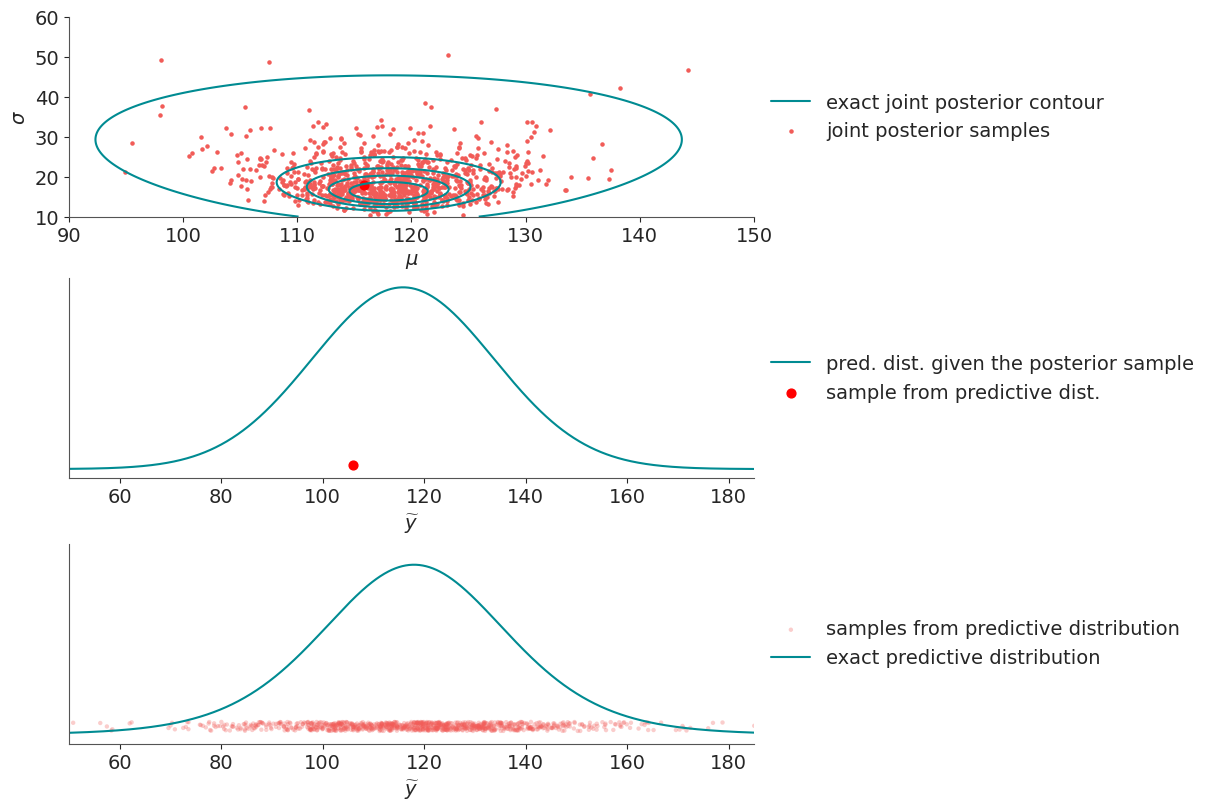

In [9]:
# Predictive PDF for first posterior sample
ynewdists = pz.Normal(mu[0], sigma[0]).pdf(xynew)

fig, (ax_joint, ax_first, ax_all) = plt.subplots(3, 1, figsize=(12, 8))

# Joint posterior
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax_joint.contour(t1, t2, Z, c_levels, colors="C0")
samps = ax_joint.scatter(mu, sigma, s=5, color="C2")
ax_joint.scatter(mu[0], sigma[0], s=40, color="r")
ax_joint.set(
    xlim=tl1, ylim=tl2,
    xlabel=r"$\mu$", ylabel=r"$\sigma$"
)
ax_joint.legend(
    [plt.Line2D([], [], color="C0"), samps],
    ["exact joint posterior contour", "joint posterior samples"],
    loc="center left", bbox_to_anchor=(1, 0.5)
)

# Predictive distribution for first sample
line1, = ax_first.plot(xynew, ynewdists)
dot = ax_first.scatter(ynew[0], 0.02 * ynewdists.max(), s=40, color="r")
ylims = ax_first.get_ylim()
ax_first.set(
    xlim=tlynew, ylim=ylims,
    xlabel=r"$\widetilde{y}$", yticks=[]
)
ax_first.legend(
    [line1, dot],
    ["pred. dist. given the posterior sample", "sample from predictive dist."],
    loc="center left", bbox_to_anchor=(1, 0.5)
)

# All predictive samples
ax_all.scatter(
    ynew,
    (0.02 + 0.05 * pz.Uniform(0, 1).rvs(*ynew.shape)) * ynewdists.max(),
    s=10, color="C2", alpha=0.3, edgecolor="None",
    label="samples from predictive distribution"
)
ax_all.plot(xynew, p_new, lw=1.5, label="exact predictive distribution")
ax_all.set(
    xlim=tlynew, ylim=ylims,
    xlabel=r"$\widetilde{y}$", yticks=[]
)
ax_all.legend(loc="center left", bbox_to_anchor=(1, 0.5));